In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys, os
import json
import math
import itertools, collections
import datetime as dt

In [2]:
import fiona
from shapely.geometry import shape
import geopandas as gp
import numpy as np
import statsmodels.formula.api as smf
from pandas.tools.plotting import plot_frame

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set_context("poster")
sns.set_context("talk", font_scale=1.4)

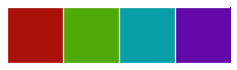

In [4]:
current_palette = sns.color_palette(sns.hls_palette(4, l=.35, s=.9))
sns.set_palette(current_palette)
sns.palplot(current_palette)
palette = itertools.cycle(sns.color_palette())

We use Alaska Albers shapefiles all around to be able to measure distances in metres. The WGS84 shapefiles from AICC and the Forest Service Active Fire Maps web portal were converted using GDAL: 

`ogr2ogr -f "ESRI Shapefile" outfile_AKAlbers.shp infile.shp -s_srs EPSG:4326 -t_SRS EPSG:3338` 

### Reload saved dataframe from file

In [5]:
datadir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/"
cleanedfireperimDF = gp.GeoDataFrame.from_file(os.path.join(datadir, "cleanedFirePerimsWithFirepoints20160228.json"))

Add a hectares column for SI units. Add yes/no black spruce fire column.

In [6]:
cleanedfireperimDF['Hectares'] = cleanedfireperimDF['Acres'] / 2.47105
cleanedfireperimDF['blacksprucefire'] = cleanedfireperimDF['PRIMARYFUE'] == "Black Spruce"

In [7]:
cleanedfireperimDF.describe()

,AREA,Acres,AgencyAcre,ESTIMATEDT,LATITUDE,LONGITUDE,MOD14count,STRUCTURES,VIIRSIcount,VIIRSMcount,Hectares,blacksprucefire
count,334,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334
mean,0,15409.942814,687.076347,15410.230240,63.748426,-153.817675,84.452096,5.979042,177.823353,38.712575,6236.192232,0.610778
std,0,34115.369953,3423.476683,34115.114533,1.858928,5.456694,183.301002,81.774003,407.177639,88.022800,13806.021713,0.488305
min,0,0.100000,0.000000,0.400000,57.615777,-165.130527,0.000000,0.000000,0.000000,0.000000,0.040469,False
25%,0,289.900000,0.000000,301.075000,62.739340,-157.817458,1.000000,0.000000,1.000000,0.000000,117.318549,0
50%,0,2788.700000,0.000000,2788.600000,64.015999,-154.601860,21.000000,0.000000,33.000000,8.500000,1128.548593,1
75%,0,14764.300000,0.725000,14764.300000,64.983333,-150.312812,82.500000,0.000000,176.500000,35.000000,5974.909451,1
max,0,312918.200000,41514.100000,312918.200000,67.916000,-141.026388,1846.000000,1455.000000,3991.000000,896.000000,126633.698225,True


In [8]:
displayperimcols = [
    u'Acres', u'Date', u'FireName', 'cleanedID', u'CONTROLDAT', 
    u'DISCOVERYD', u'FIREBEHAVI', u'GENERALCAU', u'LATITUDE', 
    u'LONGITUDE', u'MGMTOPTION', u'OUTDATE', u'PRIMARYFUE', u'STRUCTURES', 'blacksprucefire',
    'MOD14count', 'VIIRSIcount']

### Loading fire detections for later comparison

In [9]:
firehotspots = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/activefiremaps.fs.fed.us_data_fireptdata/"
mod14dir = "modis_fire_2015_344_ak_shapefile"
mod14shp = "modis_fire_2015_344_ak_AKAlbers.shp"
viirsIdir = "viirs_iband_fire_2015_344_ak_shapefile"
viirsIshp = "viirs_iband_fire_2015_344_ak_AKAlbers.shp"

In [10]:
mod14DF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, mod14dir, mod14shp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(firehotspots, viirsIdir, viirsIshp))

### We'll add the union of all buffered polygons 

In [11]:
cleanedfireperimDF.crs = mod14DF.crs

In [12]:
allbufferedpoly = cleanedfireperimDF.buffer(1000).unary_union

In [14]:
%%timeit
mod14DF.head(100).geometry.intersects(allbufferedpoly)

1 loop, best of 3: 10.6 s per loop


In [15]:
mod14DF['infireperim'] = mod14DF.geometry.intersects(allbufferedpoly)

In [31]:
viirsIDF['infireperim'] = viirsIDF.geometry.intersects(allbufferedpoly)

### Loading climate divisions

In [52]:
gisdir = "/Volumes/SCIENCE_mobile_Mac/GENERAL_GIS/ncdc.noaa.gov/AK_CLIMATE_DIVISIONS/"
climatedivisions = "AK_divisions_AKAlbers_NAD83.shp"
climatedivisions = "AK_divisions_AKAlbers_NAD83.gpkg"
climatedivisionsDF = gp.GeoDataFrame.from_file(os.path.join(gisdir, climatedivisions))

In [53]:
climatedivisionsDF

,FEATURE,Name,OBJECTID,Shape_Area,Shape_Leng,geometry
0,2,West Coast,1,2.724627e+11,11280372.799100,(POLYGON ((-446653.2996499214 1028524.81793279...
1,13,Aleutians,2,2.452534e+10,6054648.698800,(POLYGON ((-1239156.869777088 428006.022118163...
2,3,Central Interior,3,2.916655e+11,4274849.774500,"POLYGON ((53516.01222790978 1366159.232498418,..."
3,1,North Slope,4,2.217192e+11,7078975.895180,(POLYGON ((314949.6739255539 2261040.155823442...
4,4,Northeast Interior,5,1.420875e+11,2441670.570810,"POLYGON ((614539.2804472278 1703409.684173773,..."
5,5,Southeast Interior,6,1.906399e+11,2374846.386830,"POLYGON ((663417.8686240364 1456906.910430572,..."
6,6,Cook Inlet,7,6.877596e+10,2836496.847720,"POLYGON ((338247.7245545273 1281874.591666135,..."
7,8,Northwest Gulf,8,4.172442e+10,9778164.958010,(POLYGON ((-100377.8180325631 639466.303654057...
8,7,Bristol Bay,9,1.282745e+11,3489348.871290,(POLYGON ((-392123.6593679952 665055.493345350...
9,10,North Panhandle,10,5.478922e+09,649501.512627,"POLYGON ((1109889.306715986 1164423.87717057, ..."


In [54]:
mod14DF.crs == climatedivisionsDF.crs

False

In [55]:
climatedivisionsDF.crs

{u'datum': u'NAD83',
 u'lat_0': 50,
 u'lat_1': 55,
 u'lat_2': 65,
 u'lon_0': -154,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': 0}

In [56]:
mod14DF.crs

{u'datum': u'NAD83',
 u'lat_0': 50,
 u'lat_1': 55,
 u'lat_2': 65,
 u'lon_0': -154,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 'wktext': True,
 u'x_0': 0,
 u'y_0': 0}

In [74]:
cleanedfireperimDF.sort_values('Acres', ascending=False).head(10).intersection(climatedivisionsDF)

,AFSNUMBER,AREA,Acres,AgencyAcre,CONTROLDAT,DISCOVERYD,DOFNUMBER,Date,ESTIMATEDT,FALSEALARM,...,OUTDATE,PRIMARYFUE,STRUCTURES,USFSNUMBER,VIIRSIcount,VIIRSMcount,cleanedID,geometry,Hectares,blacksprucefire
265,JT00,0,312918.2,0,2015/09/29,2015/06/22,532533,2015-08-14,312918.2,None,...,2015/09/29,Black Spruce,0,PDJT00,3067,526,JT00,(POLYGON ((-20882.26378179465 1607549.50705177...,126633.698225,True
134,JTH3,0,276038.2,0,2015/09/29,2015/06/21,532449,2015-09-01,276038.2,None,...,2015/09/29,Black Spruce,0,PDJTH3,3991,896,JTH3,(POLYGON ((41658.08829758948 1775828.751329678...,111708.868700,True
232,JT05,0,223154.1,0,2015/09/10,2015/06/22,532539,2015-09-06,223154.1,None,...,2015/09/10,Mixed Trees,0,PDJT05,1453,435,JT05,(POLYGON ((-86871.17625220573 1705641.89515390...,90307.399688,False
222,JTP9,0,149359.3,0,2015/09/28,2015/06/21,532471,2015-09-09,149359.3,None,...,2015/09/28,Black Spruce,0,PDJTP9,2414,394,JTP9,(POLYGON ((-39240.57997349499 1788911.75379671...,60443.657554,True
133,JS7U,0,142650.4,0,2015/09/29,2015/06/19,532336,2015-08-31,142650.4,None,...,2015/09/29,Black Spruce,0,PDJS7U,1939,294,JS7U,(POLYGON ((11033.23273654767 1803603.367652406...,57728.657858,True
205,JS8X,0,121339.2,0,2015/09/28,2015/06/19,532362,2015-07-29,121339.2,None,...,2015/09/28,Black Spruce,0,PDJS8X,755,230,JS8X,POLYGON ((-172586.9596935369 1524230.302354595...,49104.307885,True
292,JTQ7,0,112806.8,0,2015/09/29,2015/06/21,None,2015-08-31,112806.8,None,...,2015/09/29,Black Spruce,0,None,1376,433,JTQ7,(POLYGON ((27572.15926924982 1665405.933977257...,45651.362781,True
124,JS82,0,111193.9,0,2015/09/29,2015/06/19,None,2015-07-31,111193.8,None,...,2015/09/29,Grass,0,PDJS82,1075,185,JS82,(POLYGON ((20847.26522161979 1575923.416614742...,44998.644301,False
226,JTP5,0,103967.5,0,2015/09/29,2015/06/21,None,2015-09-01,103967.5,None,...,2015/09/29,Black Spruce,0,None,1131,191,JTP5,(POLYGON ((37830.83615499216 1624708.370822584...,42074.219461,True
288,JWE2,0,100524.0,0,2015/09/29,2015/07/04,531703,2015-09-01,100524.0,None,...,2015/09/29,Black Spruce,0,None,471,163,JWE2,(POLYGON ((61475.03156174919 1529359.671351367...,40680.682301,True


In [65]:
cleanedfireperimDF.sort_values('Acres', ascending=False).head(10)

,AFSNUMBER,AREA,Acres,AgencyAcre,CONTROLDAT,DISCOVERYD,DOFNUMBER,Date,ESTIMATEDT,FALSEALARM,...,OUTDATE,PRIMARYFUE,STRUCTURES,USFSNUMBER,VIIRSIcount,VIIRSMcount,cleanedID,geometry,Hectares,blacksprucefire
265,JT00,0,312918.2,0,2015/09/29,2015/06/22,532533,2015-08-14,312918.2,None,...,2015/09/29,Black Spruce,0,PDJT00,3067,526,JT00,(POLYGON ((-20882.26378179465 1607549.50705177...,126633.698225,True
134,JTH3,0,276038.2,0,2015/09/29,2015/06/21,532449,2015-09-01,276038.2,None,...,2015/09/29,Black Spruce,0,PDJTH3,3991,896,JTH3,(POLYGON ((41658.08829758948 1775828.751329678...,111708.868700,True
232,JT05,0,223154.1,0,2015/09/10,2015/06/22,532539,2015-09-06,223154.1,None,...,2015/09/10,Mixed Trees,0,PDJT05,1453,435,JT05,(POLYGON ((-86871.17625220573 1705641.89515390...,90307.399688,False
222,JTP9,0,149359.3,0,2015/09/28,2015/06/21,532471,2015-09-09,149359.3,None,...,2015/09/28,Black Spruce,0,PDJTP9,2414,394,JTP9,(POLYGON ((-39240.57997349499 1788911.75379671...,60443.657554,True
133,JS7U,0,142650.4,0,2015/09/29,2015/06/19,532336,2015-08-31,142650.4,None,...,2015/09/29,Black Spruce,0,PDJS7U,1939,294,JS7U,(POLYGON ((11033.23273654767 1803603.367652406...,57728.657858,True
205,JS8X,0,121339.2,0,2015/09/28,2015/06/19,532362,2015-07-29,121339.2,None,...,2015/09/28,Black Spruce,0,PDJS8X,755,230,JS8X,POLYGON ((-172586.9596935369 1524230.302354595...,49104.307885,True
292,JTQ7,0,112806.8,0,2015/09/29,2015/06/21,None,2015-08-31,112806.8,None,...,2015/09/29,Black Spruce,0,None,1376,433,JTQ7,(POLYGON ((27572.15926924982 1665405.933977257...,45651.362781,True
124,JS82,0,111193.9,0,2015/09/29,2015/06/19,None,2015-07-31,111193.8,None,...,2015/09/29,Grass,0,PDJS82,1075,185,JS82,(POLYGON ((20847.26522161979 1575923.416614742...,44998.644301,False
226,JTP5,0,103967.5,0,2015/09/29,2015/06/21,None,2015-09-01,103967.5,None,...,2015/09/29,Black Spruce,0,None,1131,191,JTP5,(POLYGON ((37830.83615499216 1624708.370822584...,42074.219461,True
288,JWE2,0,100524.0,0,2015/09/29,2015/07/04,531703,2015-09-01,100524.0,None,...,2015/09/29,Black Spruce,0,None,471,163,JWE2,(POLYGON ((61475.03156174919 1529359.671351367...,40680.682301,True


### Plotting

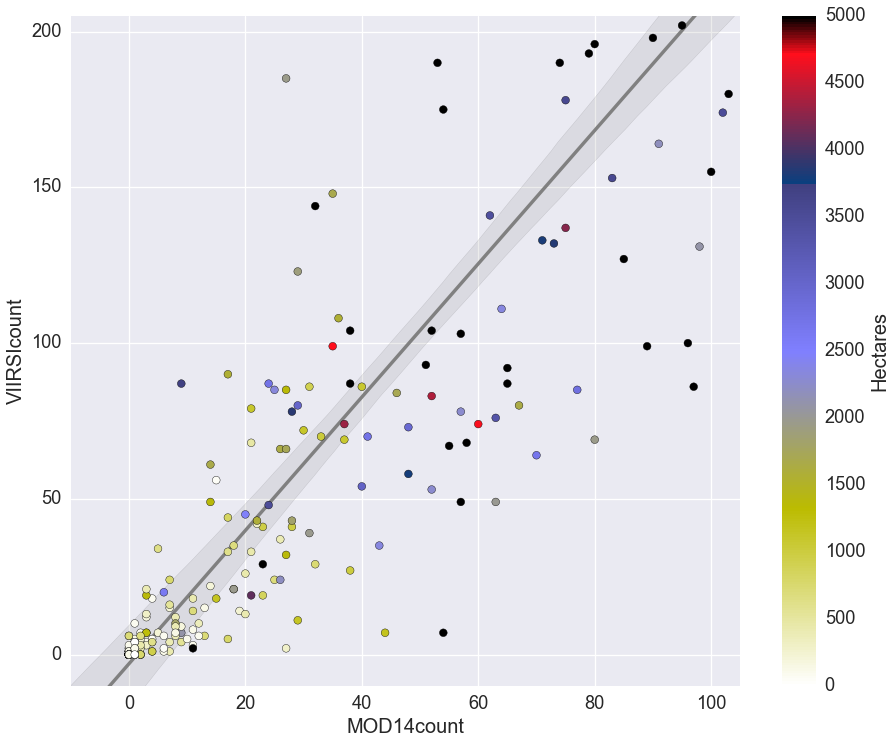

In [10]:
SAVEFIG = False
palette = itertools.cycle(sns.color_palette())
xlim = (-10, 105)
ylim = (-10, 205)
ax1 = plot_frame(cleanedfireperimDF, kind='scatter', 
                                 x="MOD14count", 
                                 y="VIIRSIcount", 
                                 xlim=xlim, 
                                 ylim=ylim, 
                                 s=60, 
                                 c='Hectares',
                                 cmap="gist_stern_r",
                                 vmin=0, 
                                 vmax=5000,
                                 colorbar=True,
                                 legend=True,
                                 figsize=(15, 12),
                                 sharex=False,
                                 zorder=2
                                )
sns.regplot(
    x="MOD14count", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )

#ax1.set_aspect("equal")
f = plt.gcf()
#f.subplots_adjust(bottom=0.4)
#x = np.array([xlim[0], xlim[1]])
#y = intercept + slope * x
#plt.plot(x, y, 'r-', color=next(palette))

if SAVEFIG:
    f.savefig('/Users/cwaigl/Desktop/samplefigure_close')

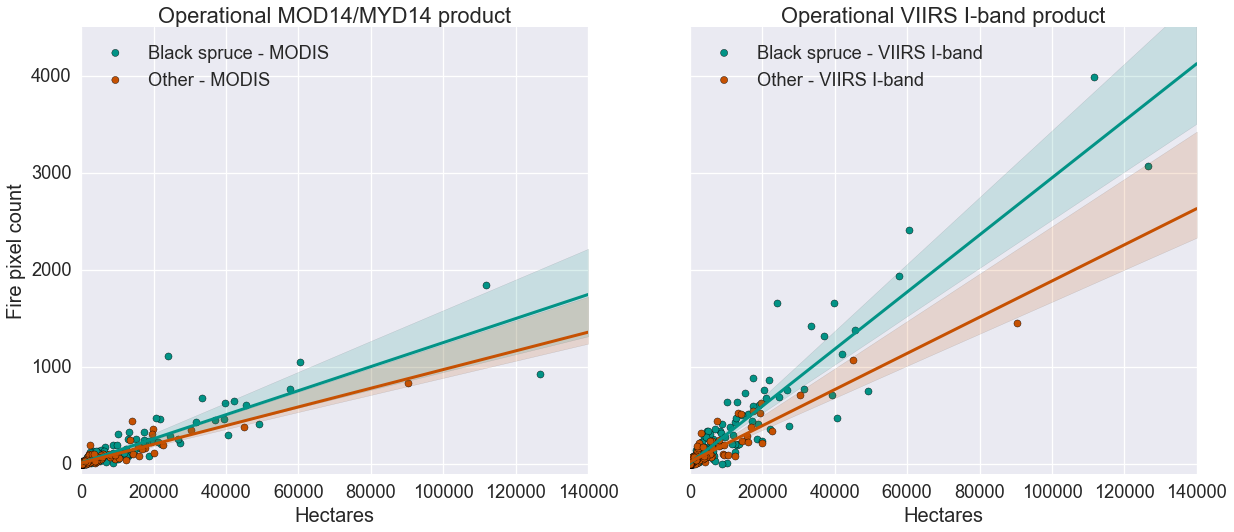

In [11]:
plotpalette = sns.xkcd_palette(['teal', 'dark orange', ])
palette = itertools.cycle(plotpalette)
xlim = (-100, 140000)
ylim = (-100, 4500)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8), sharex=True, sharey=True)
                              
plot_frame(cleanedfireperimDF[
        cleanedfireperimDF.PRIMARYFUE == "Black Spruce"], 
        kind='scatter', x='Hectares', y="MOD14count", s=50, 
        ax=ax0, label="Black spruce - MODIS", color=next(palette))
plot_frame(cleanedfireperimDF[
        cleanedfireperimDF.PRIMARYFUE != "Black Spruce"], 
        kind='scatter', x='Hectares', y="MOD14count", s=50, 
        ax=ax0, label="Other - MODIS", color=next(palette))

palette = itertools.cycle(plotpalette)
plot_frame(cleanedfireperimDF[
        cleanedfireperimDF.PRIMARYFUE == "Black Spruce"], 
        kind='scatter', x='Hectares', y="VIIRSIcount", s=50, 
        ax=ax1, label="Black spruce - VIIRS I-band", color=next(palette))
plot_frame(cleanedfireperimDF[
        cleanedfireperimDF.PRIMARYFUE != "Black Spruce"], 
        kind='scatter', x='Hectares', y="VIIRSIcount", s=50, 
        ax=ax1, label="Other - VIIRS I-band", color=next(palette))

palette = itertools.cycle(plotpalette)
sns.regplot(
    x="Hectares", 
    y="MOD14count", 
    data=cleanedfireperimDF.loc[cleanedfireperimDF.blacksprucefire],
    ax=ax0,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1, 'lw': 3}
    )
sns.regplot(
    x="Hectares", 
    y="MOD14count", 
    data=cleanedfireperimDF.loc[~cleanedfireperimDF.blacksprucefire],
    ax=ax0,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1, 'lw': 3}
    )
palette = itertools.cycle(plotpalette)
sns.regplot(
    x="Hectares", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF.loc[cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1, 'lw': 3}
    )
sns.regplot(
    x="Hectares", 
    y="VIIRSIcount", 
    data=cleanedfireperimDF.loc[~cleanedfireperimDF.blacksprucefire],
    ax=ax1,
    color=next(palette),
    scatter=False,
    line_kws={'zorder': 1, 'lw': 3}
    )
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax0.set_ylabel('Fire pixel count')
ax0.set_title('Operational MOD14/MYD14 product')
ax1.set_title('Operational VIIRS I-band product')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')

In [97]:
fig.savefig('/Users/cwaigl/Desktop/pixelcount_fuel.png', dpi=200, bbox_inches='tight')

### Inspecting the cleaned perimeter dataset

Here is the reason I kept these columns. I'll change the case of the management options... 

In [35]:
cleanedfireperimDF['PRIMARYFUE'].value_counts()

Black Spruce                   204
Other                           41
Grass                           28
Mixed (Hardwoods/Softwoods)     17
Unknown                         15
Tundra                          14
Mixed Trees                     11
Hardwoods                        2
White Spruce                     1
Live White Spruce                1
Name: PRIMARYFUE, dtype: int64

In [36]:
cleanedfireperimDF['FIREBEHAVI'].value_counts()

Running       86
Creeping      74
Smoldering    44
Crowning       1
Name: FIREBEHAVI, dtype: int64

In [37]:
cleanedfireperimDF['MGMTOPTION'].value_counts()

Limited       207
Full           75
Modified       42
Critical        6
Prescribed      4
Name: MGMTOPTION, dtype: int64

In [38]:
cleanedfireperimDF['GENERALCAU'].value_counts()

Lightning     302
Human          27
Prescribed      5
Name: GENERALCAU, dtype: int64

In [39]:
cleanedfireperimDF.sort_values(by="Acres", ascending=False).head(n=10)[displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
265,312918.2,2015-08-14,Big Creek Two,JT00,2015/09/29,2015/06/22,Smoldering,Lightning,64.734333,-155.009000,Limited,2015/09/29,Black Spruce,0,True,924,3067
134,276038.2,2015-09-01,Sushgitit Hills,JTH3,2015/09/29,2015/06/21,Running,Lightning,66.032305,-153.022305,Limited,2015/09/29,Black Spruce,0,True,1846,3991
232,223154.1,2015-09-06,Holtnakatna,JT05,2015/09/10,2015/06/22,Smoldering,Lightning,65.184333,-156.214833,Limited,2015/09/10,Mixed Trees,0,False,834,1453
222,149359.3,2015-09-09,Isahultila,JTP9,2015/09/28,2015/06/21,Running,Lightning,65.869388,-154.681083,Modified,2015/09/28,Black Spruce,0,True,1050,2414
133,142650.4,2015-08-31,Rock,JS7U,2015/09/29,2015/06/19,Creeping,Lightning,66.000444,-153.999944,Full,2015/09/29,Black Spruce,0,True,777,1939
205,121339.2,2015-07-29,Blazo,JS8X,2015/09/28,2015/06/19,Running,Lightning,63.418333,-157.611166,Limited,2015/09/28,Black Spruce,0,True,414,755
292,112806.8,2015-08-31,Bering Creek,JTQ7,2015/09/29,2015/06/21,Running,Lightning,64.983333,-153.550000,Limited,2015/09/29,Black Spruce,0,True,604,1376
124,111193.9,2015-07-31,Sea,JS82,2015/09/29,2015/06/19,Running,Lightning,64.100000,-153.733333,Limited,2015/09/29,Grass,0,False,383,1075
226,103967.5,2015-09-01,Big Mud River 1,JTP5,2015/09/29,2015/06/21,Creeping,Lightning,64.673666,-152.925833,Limited,2015/09/29,Black Spruce,0,True,644,1131
288,100524.0,2015-09-01,Munsatli 2,JWE2,2015/09/29,2015/07/04,Creeping,Lightning,63.629166,-153.019166,Limited,2015/09/29,Black Spruce,0,True,295,471


In [27]:
cleanedfireperimDF['RelativeVIIRSICount'] = cleanedfireperimDF['VIIRSIcount'] / cleanedfireperimDF['Hectares'] 
cleanedfireperimDF['RelativeMOD14Count'] = cleanedfireperimDF['MOD14count'] / cleanedfireperimDF['Hectares'] 

cleanedfireperimDF[cleanedfireperimDF['Hectares'] > 1000].sort_values(
    by="RelativeVIIRSICount", ascending=True).head(n=20)[
    displayperimcols + ['Hectares', 'RelativeVIIRSICount', 'RelativeMOD14Count']]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount,Hectares,RelativeVIIRSICount,RelativeMOD14Count
103,3342.3,2015-07-11,Copenhagen,JW07,2015/08/26,2015/07/04,None,Lightning,58.903638,-157.404611,Modified,2015/08/26,Other,0,False,0,0,1352.582910,0.000000,0.000000
154,21698.0,2015-07-27,Mingvk Lake,JY50,2015/09/28,2015/07/19,Running,Lightning,65.416666,-164.533333,Limited,2015/09/28,Black Spruce,0,True,11,2,8780.882621,0.000228,0.001253
64,25259.8,2015-06-07,Bogus Creek,JRD3,2015/09/21,2015/05/31,None,Lightning,61.205166,-160.336500,Full,2015/09/21,Black Spruce,2,True,54,7,10222.294166,0.000685,0.005283
41,5166.7,2015-07-04,Copenhagen Creek,JT2A,2015/08/26,2015/06/22,None,Lightning,58.841000,-157.543166,Modified,2015/08/26,Grass,0,False,9,7,2090.892536,0.003348,0.004304
311,16869.2,2015-07-21,Poorman Creek,JUT6,2015/09/28,2015/06/26,Running,Lightning,63.977500,-155.931833,Limited,2015/09/28,Black Spruce,0,True,23,29,6826.733575,0.004248,0.003369
183,10109.2,2015-07-30,Wapoo,JUU0,2015/08/21,2015/06/26,Running,Lightning,63.680000,-157.883000,Limited,2015/08/21,Other,0,False,21,19,4091.054410,0.004644,0.005133
241,3141.5,2015-07-10,Beaver Creek,504661,2015/08/26,2015/06/26,None,Lightning,63.125611,-156.686194,Modified,2015/08/26,Black Spruce,0,True,3,7,1271.321908,0.005506,0.002360
164,4480.1,2015-07-19,Dishna River,JU3G,2015/09/21,2015/06/23,None,Lightning,63.354416,-157.207000,Limited,2015/09/21,Black Spruce,0,True,8,10,1813.034945,0.005516,0.004412
54,2902.3,2015-06-03,Seventymile,JQ2N,2015/08/15,2015/05/24,Smoldering,Lightning,64.900000,-141.383333,Full,2015/08/15,Black Spruce,0,True,44,7,1174.520953,0.005960,0.037462
156,30928.4,2015-07-12,Ophir Creek,JT4K,2015/09/21,2015/06/23,None,Lightning,61.318666,-159.854666,Limited,2015/09/21,Mixed (Hardwoods/Softwoods),0,False,38,87,12516.298739,0.006951,0.003036


Now let's plot a few of the largest ones

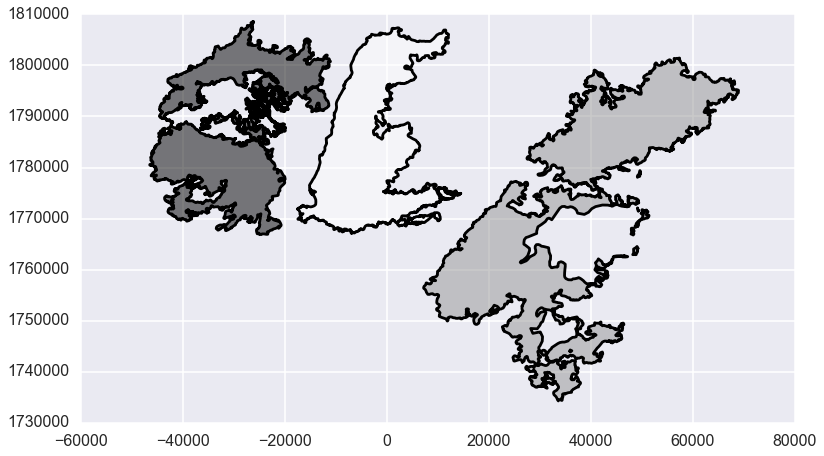

In [49]:
cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', ])].plot()

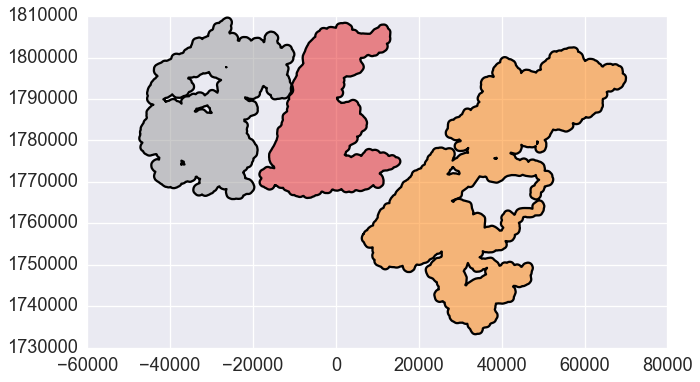

In [16]:
cleanedfireperimDF[cleanedfireperimDF.FireName.isin(['Sushgitit Hills', 'Rock', 'Isahultila', ])].geometry.buffer(1000).plot()

## Cycling through fire perimeters and fire detections (MOD14 and VIIRS I-band)

How many fires were not detected? Further data inspection

In [40]:
print("MOD14")
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.MOD14count == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.MOD14count == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.Acres[cleanedfireperimDF.MOD14count == 0]))))

MOD14
Number of undetected fires: 77
Percentage of undetected fires: 23.05
Acreage of largest undetected fire: 3342.3


In [41]:
print("VIIRS I-band")
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.VIIRSIcount == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.VIIRSIcount == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.Acres[cleanedfireperimDF.VIIRSIcount == 0]))))

VIIRS I-band
Number of undetected fires: 75
Percentage of undetected fires: 22.46
Acreage of largest undetected fire: 3342.3


In [44]:
print("Largest pixel count for individual fire:")
print("MOD14: {}".format(max(cleanedfireperimDF.MOD14count)))
print("VIIRS I-band: {}".format(max(cleanedfireperimDF.VIIRSIcount)))

Largest pixel count for individual fire:
MOD14: 1846
VIIRS I-band: 3991


In [16]:
print(sum(mod14DF.infireperim), sum(~mod14DF.infireperim), sum(~mod14DF.infireperim)/sum(mod14DF.infireperim))

26102 568 0.0217607846142


In [33]:
print(sum(viirsIDF.infireperim), sum(~viirsIDF.infireperim), sum(~viirsIDF.infireperim)/sum(viirsIDF.infireperim))

53562 1115 0.0208169971248


In [18]:
cleanedfireperimDF[cleanedfireperimDF.MOD14count==max(cleanedfireperimDF.MOD14count)][displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
134,276038.2,2015-09-01,Sushgitit Hills,JTH3,2015/09/29,2015/06/21,Running,Lightning,66.032305,-153.022305,Limited,2015/09/29,Black Spruce,0,True,1846,3991


In [19]:
cleanedfireperimDF[cleanedfireperimDF.FireName.str.startswith("Sockeye")][displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
35,7264.9,2015-07-04,Sockeye,JSM8,2015/07/22,2015/06/14,None,Human,61.844861,-150.085444,Full,2015/10/01,Mixed (Hardwoods/Softwoods),1455,False,48,73


In [20]:
cleanedfireperimDF.groupby(["PRIMARYFUE"])["MOD14count"].mean()

PRIMARYFUE
Black Spruce                   104.700980
Grass                           26.392857
Hardwoods                        4.000000
Live White Spruce               96.000000
Mixed (Hardwoods/Softwoods)     44.882353
Mixed Trees                    118.818182
Other                           48.731707
Tundra                          41.000000
Unknown                         84.333333
White Spruce                    98.000000
Name: MOD14count, dtype: float64

In [24]:
cleanedfireperimDF.groupby(["PRIMARYFUE"])["VIIRSIcount"].mean()

PRIMARYFUE
Black Spruce                   225.828431
Grass                           72.464286
Hardwoods                        3.000000
Live White Spruce              100.000000
Mixed (Hardwoods/Softwoods)     74.235294
Mixed Trees                    204.090909
Other                          100.780488
Tundra                          89.285714
Unknown                        144.600000
White Spruce                   131.000000
Name: VIIRSIcount, dtype: float64

In [22]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["MOD14count"].mean()

MGMTOPTION
Critical      53.333333
Full          71.306667
Limited       89.724638
Modified      94.428571
Prescribed     0.000000
Name: MOD14count, dtype: float64

In [23]:
cleanedfireperimDF.groupby(["MGMTOPTION"])["Acres"].mean()

MGMTOPTION
Critical      11613.550000
Full          13150.844000
Limited       16741.729952
Modified      14824.861905
Prescribed      686.000000
Name: Acres, dtype: float64

## Now VIIRS I-band

## Data inspection for badly detected fires etc.

In [25]:
cleanedfireperimDF[
    (cleanedfireperimDF.VIIRSIcount <10)
    #& (cleanedfireperimDF.MOD14count == 0)
    ].sort_values(
        by='Acres', ascending=False
        ).head(15)[displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
64,25259.8,2015-06-07,Bogus Creek,JRD3,2015/09/21,2015/05/31,None,Lightning,61.205166,-160.336500,Full,2015/09/21,Black Spruce,2,True,54,7
154,21698.0,2015-07-27,Mingvk Lake,JY50,2015/09/28,2015/07/19,Running,Lightning,65.416666,-164.533333,Limited,2015/09/28,Black Spruce,0,True,11,2
41,5166.7,2015-07-04,Copenhagen Creek,JT2A,2015/08/26,2015/06/22,None,Lightning,58.841000,-157.543166,Modified,2015/08/26,Grass,0,False,9,7
103,3342.3,2015-07-11,Copenhagen,JW07,2015/08/26,2015/07/04,None,Lightning,58.903638,-157.404611,Modified,2015/08/26,Other,0,False,0,0
241,3141.5,2015-07-10,Beaver Creek,504661,2015/08/26,2015/06/26,None,Lightning,63.125611,-156.686194,Modified,2015/08/26,Black Spruce,0,True,3,7
54,2902.3,2015-06-03,Seventymile,JQ2N,2015/08/15,2015/05/24,Smoldering,Lightning,64.900000,-141.383333,Full,2015/08/15,Black Spruce,0,True,44,7
289,2362.6,2015-08-11,Bear Island Lake,JX1M,2015/09/21,2015/07/11,None,Lightning,63.490333,-153.344333,Full,2015/09/21,Black Spruce,0,True,4,1
195,2060.1,2015-08-04,Little Black,JWY7,2015/10/05,2015/07/05,Creeping,Lightning,65.700000,-143.233333,Limited,2015/10/05,Black Spruce,0,True,0,0
132,1949.4,2015-09-01,Foraker,JW3N,2015/08/25,2015/07/06,Creeping,Lightning,63.639583,-152.109111,Limited,2015/08/25,Black Spruce,0,True,17,5
81,1930.0,2015-07-11,Little Kokwok,504727,2015/08/12,2015/07/10,None,Lightning,59.553611,-158.359722,Full,2015/08/12,Mixed (Hardwoods/Softwoods),0,False,2,0


In [26]:
cleanedfireperimDF[
    (cleanedfireperimDF.VIIRSIcount < 50) 
    & (cleanedfireperimDF.Acres > 10000)
#    & (cleanedfireperimDF.MOD14count > 10)
    ][displayperimcols]

,Acres,Date,FireName,cleanedID,CONTROLDAT,DISCOVERYD,FIREBEHAVI,GENERALCAU,LATITUDE,LONGITUDE,MGMTOPTION,OUTDATE,PRIMARYFUE,STRUCTURES,blacksprucefire,MOD14count,VIIRSIcount
37,15740.4,2015-09-18,Salmon River,JZ1M,2015/09/10,2015/07/23,Running,Lightning,67.158333,-159.307500,Modified,2015/09/10,Black Spruce,0,True,57,49
64,25259.8,2015-06-07,Bogus Creek,JRD3,2015/09/21,2015/05/31,None,Lightning,61.205166,-160.336500,Full,2015/09/21,Black Spruce,2,True,54,7
154,21698.0,2015-07-27,Mingvk Lake,JY50,2015/09/28,2015/07/19,Running,Lightning,65.416666,-164.533333,Limited,2015/09/28,Black Spruce,0,True,11,2
183,10109.2,2015-07-30,Wapoo,JUU0,2015/08/21,2015/06/26,Running,Lightning,63.680000,-157.883000,Limited,2015/08/21,Other,0,False,21,19
311,16869.2,2015-07-21,Poorman Creek,JUT6,2015/09/28,2015/06/26,Running,Lightning,63.977500,-155.931833,Limited,2015/09/28,Black Spruce,0,True,23,29


In [28]:
cleanedfireperimDF[['Acres', 'MOD14count', 'VIIRSMcount', 'VIIRSIcount', 'LATITUDE', 'LONGITUDE']].corr()

,Acres,MOD14count,VIIRSMcount,VIIRSIcount,LATITUDE,LONGITUDE
Acres,1.000000,0.893578,0.895635,0.925758,0.146952,-0.065596
MOD14count,0.893578,1.000000,0.976974,0.963767,0.227166,0.010226
VIIRSMcount,0.895635,0.976974,1.000000,0.951844,0.218221,-0.000797
VIIRSIcount,0.925758,0.963767,0.951844,1.000000,0.196731,0.003755
LATITUDE,0.146952,0.227166,0.218221,0.196731,1.000000,0.360729
LONGITUDE,-0.065596,0.010226,-0.000797,0.003755,0.360729,1.000000


In [29]:
cleanedfireperimDF.blacksprucefire.value_counts()

True     204
False    130
Name: blacksprucefire, dtype: int64

### Statistics! 

Somehow Pandas-style plotting doesn't work on GeoPandas GeoDataFrames. Until I find a better solution, I'm makeing a copy that's just a regular dataframe:

In [64]:
keepperimcols = list(cleanedfireperimDF.columns)
keepperimcols.remove('geometry')
cleanedfireperimDF_forstats = cleanedfireperimDF[keepperimcols].copy()
type(cleanedfireperimDF_forstats)

pandas.core.frame.DataFrame

In [30]:
results = smf.ols('VIIRSIcount ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     4334.
Date:                Mon, 20 Jun 2016   Prob (F-statistic):          1.32e-192
Time:                        23:00:17   Log-Likelihood:                -2039.1
No. Observations:                 334   AIC:                             4082.
Df Residuals:                     332   BIC:                             4090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.9779      6.555     -0.454      0.6

In [72]:
results = smf.ols('MOD14count ~ Acres', cleanedfireperimDF.loc[cleanedfireperimDF['blacksprucefire']]).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             MOD14count   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     803.2
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           2.56e-72
Time:                        13:21:12   Log-Likelihood:                -1222.2
No. Observations:                 204   AIC:                             2448.
Df Residuals:                     202   BIC:                             2455.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.6442      7.543      1.676      0.0

In [73]:
results = smf.ols('VIIRSIcount ~ Acres', cleanedfireperimDF.loc[cleanedfireperimDF['blacksprucefire']]).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1498.
Date:                Tue, 01 Mar 2016   Prob (F-statistic):           2.25e-95
Time:                        13:21:14   Log-Likelihood:                -1335.1
No. Observations:                 204   AIC:                             2674.
Df Residuals:                     202   BIC:                             2681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.1650     13.122      0.546      0.5

In [74]:
results.params

Intercept    7.164995
Acres        0.011905
dtype: float64

In [58]:
results = smf.ols('VIIRSIcount ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            VIIRSIcount   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     4334.
Date:                Thu, 02 Jun 2016   Prob (F-statistic):          1.32e-192
Time:                        16:33:45   Log-Likelihood:                -2039.1
No. Observations:                 334   AIC:                             4082.
Df Residuals:                     332   BIC:                             4090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.9779      6.555     -0.454      0.6

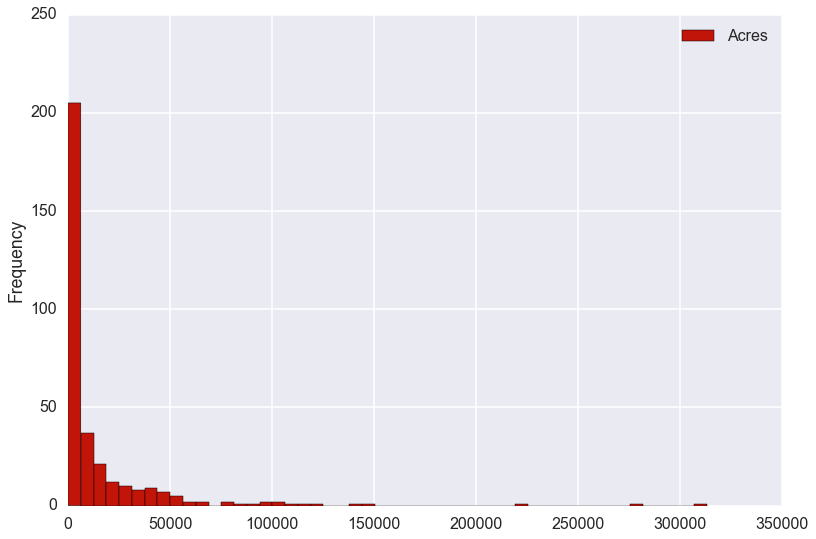

In [299]:
ax1 = cleanedfireperimDF["Acres"].plot(kind='hist', bins=50, legend=True)

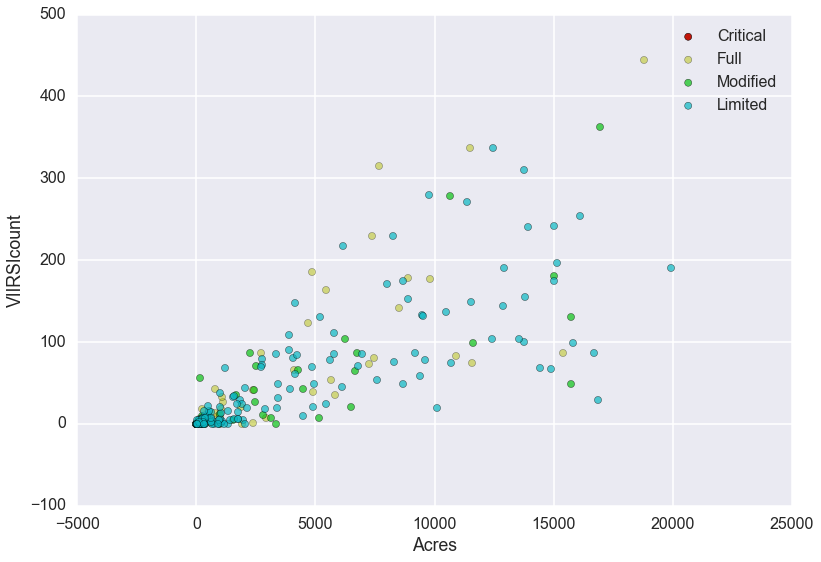

In [353]:
palette = itertools.cycle(sns.color_palette())
ax1 = cleanedfireperimDF[
    (cleanedfireperimDF.MGMTOPTION == "Critical")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", s=50, label="Critical", color=next(palette))
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Full")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Full", color=next(palette), alpha=0.5)
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Modified")& (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(
    kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Modified", color=next(palette), alpha=0.7)
cleanedfireperimDF_forstats[
    (cleanedfireperimDF.MGMTOPTION == "Limited") & (cleanedfireperimDF.Acres <= 20000 )
    ][['Acres', 'VIIRSIcount']].plot(kind='scatter', x='Acres', y="VIIRSIcount", ax=ax1, s=50, label="Limited", color=next(palette), alpha=0.7)



In [ ]:
%debug
cleanedfireperimDF.drop(['blacksprucefire'], axis=1).to_crs(epsg=4326).to_file(
    os.path.join(datadir, "cleanedFirePerimsWithFirepoints20160228_new.gpkg"), 
    driver="GPKG")

In [64]:
cleanedfireperimDF.drop(['blacksprucefire'], axis=1).columns

Index([      u'AFSNUMBER',            u'AREA',           u'Acres',
            u'AgencyAcre',      u'CONTROLDAT',      u'DISCOVERYD',
             u'DOFNUMBER',            u'Date',      u'ESTIMATEDT',
            u'FALSEALARM',      u'FIREBEHAVI',        u'FireName',
            u'GENERALCAU',        u'LATITUDE',       u'LONGITUDE',
            u'MGMTOPTION',      u'MOD14count',            u'NAME',
               u'OUTDATE',      u'PRIMARYFUE',      u'STRUCTURES',
            u'USFSNUMBER',     u'VIIRSIcount',     u'VIIRSMcount',
             u'cleanedID',        u'geometry',        u'Hectares',
       u'blacksprucefire'],
      dtype='object')

In [35]:
mod14DF['inbufferedfireperim'] = 0
viirsIDF['inbufferedfireperim'] = 0

In [47]:
mod14DF.loc[mod14DF.infireperim, 'inbufferedfireperim'] = 1
viirsIDF.loc[viirsIDF.infireperim, 'inbufferedfireperim'] = 1


In [48]:
mod14DF.head(10)

,AREA,CONF,DATE,FIRE_,FIRE_ID,FRP,GMT,JULIAN,LAT,LONG,PERIMETER,SAT_SRC,SPIX,SRC,TEMP,TPIX,geometry,infireperim,inbufferedfireperim
0,0,51,2015-08-25,1,556152,18.5,548,237,70.320,-148.538,0,T,1.5,uaf,302.8,1.2,POINT (209006.9285980303 2268502.338402809),False,0
1,0,100,2015-10-07,2,578084,52.0,710,280,70.292,-148.422,0,T,1.1,gsfc,328.2,1.0,POINT (213692.6530392757 2265815.761972296),False,0
2,0,100,2015-10-07,3,578083,62.5,710,280,70.289,-148.449,0,T,1.1,gsfc,334.2,1.0,POINT (212688.1326305367 2265401.676873978),False,0
3,0,51,2015-07-04,4,453637,5.7,2252,185,68.057,-153.823,0,T,1.4,uaf,306.8,1.2,POINT (7444.753524688874 2010738.905582397),False,0
4,0,61,2015-07-26,5,480744,10.6,2354,207,67.933,-163.619,0,T,2.0,uaf,305.5,1.4,POINT (-405150.1668644578 2026400.42526813),True,1
5,0,54,2015-07-27,6,481238,7.2,2258,208,67.930,-163.618,0,T,1.0,uaf,308.5,1.0,POINT (-405156.2609069129 2026065.767510198),True,1
6,0,65,2015-07-25,7,480215,82.8,635,206,67.929,-163.620,0,T,2.4,gsfc,316.0,1.5,POINT (-405255.8968379239 2025968.450820677),True,1
7,0,70,2015-07-28,8,481829,10.7,2203,209,67.926,-163.621,0,T,1.4,uaf,310.6,1.2,POINT (-405345.6625455436 2025645.993561612),True,1
8,0,45,2015-07-27,9,184541,29.2,10,208,67.924,-163.617,0,A,2.1,gsfc,310.9,1.4,POINT (-405210.2604228943 2025402.540562532),True,1
9,0,58,2015-07-26,10,480743,32.9,49,207,67.924,-163.612,0,T,3.8,uaf,304.0,1.8,POINT (-405001.0600063034 2025372.040695955),True,1


In [49]:
mod14DF.drop(['infireperim'], axis=1).to_file(os.path.join(datadir, "mod14_with_flags.shp"))

In [50]:
viirsIDF.drop(['infireperim'], axis=1).to_file(os.path.join(datadir, "viirsI_with_flags.shp"))